First, import needed modules

In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
from shapely import wkt
from shapely.ops import unary_union

/opt/homebrew/Caskroom/miniconda/base/envs/vscode/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Initalize variables

In [2]:
shapely.speedups.enable()
path = os.getcwd()
print(path)

/Users/jan/Dropbox/UP_EPQM/2222/MA/powerlinemonsters


Load shapefile with municipality and state boundaries and plot it for inspection

<AxesSubplot:>

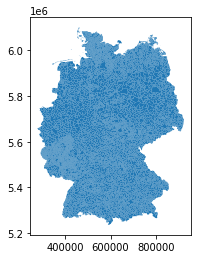

In [3]:
municipalities = gpd.read_file(f'{path}/data/geodata/VG250_GEM.shp')
states = gpd.read_file(f'{path}/data/geodata/VG250_LAN.shp')
de = gpd.read_file(f'{path}/data/geodata/VG250_STA.shp')
municipalities.plot()

Drop polygons which represent waterbodies

<AxesSubplot:>

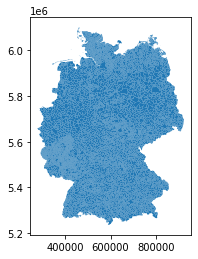

In [4]:
municipalities = municipalities[municipalities['GF'] == 4] 
#municipalities = municipalities[municipalities["BEZ"] != 'Gemeindefreies Gebiet']
municipalities.plot()

Inspect gemeindefreie Gebiete (unincorporated areas, mostly forests)

In [5]:
mun_unincorporated = municipalities[municipalities['BEZ'] == 'Gemeindefreies Gebiet']
mun_unincorporated.shape
# There are 220 unicorporated areas, only two are inhabitated

(220, 25)

Create geopandas df with unihabited unincorporated areas

In [6]:
mun_unincorporated = municipalities[municipalities['BEZ'] == 'Gemeindefreies Gebiet']
mun_unincorporated = mun_unincorporated[mun_unincorporated['EWZ'] == 0]
mun_unincorporated.shape

(218, 25)

The data use the European Terrestrial Reference System 1989 as coordinate reference system (CRS), units are metres

In [7]:
municipalities.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Load shapefiles with power lines

In [8]:
pl_05 = gpd.read_file(f'{path}/data/geodata/powerlines_05.shp')
pl_09 = gpd.read_file(f'{path}/data/geodata/powerlines_09.shp')
pl_13 = gpd.read_file(f'{path}/data/geodata/powerlines_13.shp')

Combine municipalities and powerlines in a plot

In [10]:
# 2005
pl_05.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
pl_05.plot(ax=ax, color='red', lw=2, zorder=3)
plt.title('DENA 2005 projects \n All projects (new and retrofit)', fontsize=20)
plt.savefig(f'{path}/figures/DENA2005_all_projects.png')
plt.close()

In [11]:
# 2009
pl_09.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
pl_09.plot(ax=ax, color='red', lw=2, zorder=3)
plt.title('ENLAG 2009 projects \n All projects (new and retrofit)', fontsize=20)
plt.savefig(f'{path}/figures/ENLAG2009_all_projects.png')
plt.close()

In [12]:
# 2013
pl_13.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
pl_13.plot(ax=ax, color='red', lw=2, zorder=3)
plt.title('BBPlG 2013 projects \n All projects (new and retrofit)', fontsize=20)
plt.savefig(f'{path}/figures/BBPLG2013_all_projects.png')
plt.close()

Load shapefiles with start and endpoints

In [13]:
start_05 = gpd.read_file(f'{path}/data/geodata/startpoints_05.shp')
end_05 = gpd.read_file(f'{path}/data/geodata/endpoints_05.shp')
start_09 = gpd.read_file(f'{path}/data/geodata/startpoints_09.shp')
end_09 = gpd.read_file(f'{path}/data/geodata/endpoints_09.shp')
start_13 = gpd.read_file(f'{path}/data/geodata/startpoints_13.shp')
end_13 = gpd.read_file(f'{path}/data/geodata/endpoints_13.shp')

Concatenate start and endpoints dfs

In [14]:
# First rename columns to allow concatenation
starts = [start_05, start_09, start_13]
for df in starts: 
    df.rename(columns = {'Start': 'Name', 'Int_start': 'Int'}, inplace = True)
ends = [end_05, end_09, end_13]
for df in ends: 
    df.rename(columns = {'End': 'Name', 'Int_end': 'Int'}, inplace = True)

In [15]:
points_05 = pd.concat([start_05, end_05])
points_09 = pd.concat([start_09, end_09])
points_13 = pd.concat([start_13, end_13])

Filter out Retrofitting projects, short lines and intermediate start- and endpoints

In [16]:
# For 2005 there are no retrofit and short projects
points_05 = points_05[points_05['Int'] != 1]
points_05.shape

(22, 7)

In [17]:
# For 2009 there are no retrofit projects
pl_09 = pl_09[pl_09['Short'] != 1]
points_09 = points_09[points_09['Int'] != 1]
points_09 = points_09[points_09['Short'] != 1]

In [18]:
pl_13 = pl_13[pl_13['New'] == 1]
pl_13 = pl_13[pl_13['Short'] != 1]
points_13 = points_13[points_13['New'] == 1]
points_13 = points_13[points_13['Short'] != 1]
points_13 = points_13[points_13['Int'] != 1]

Export new powerline shapefile

In [19]:
pl_09.to_file(f'{path}/data/geodata/new_powerlines_09.shp')
pl_13.to_file(f'{path}/data/geodata/new_powerlines_13.shp')

Create dataset with all powerlines

In [27]:
dfs = [pl_05, pl_09, pl_13]
years = ['2005', '2009', '2013']
for df, year in zip(dfs, years):
    df['year'] = year
all_powerlines = pd.concat(dfs)
all_powerlines.to_file(f'{path}/data/geodata/all_powerlines.shp')

Combine municipalities and ALL new powerlines in a plot

In [26]:
all_powerlines.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
all_powerlines.plot(ax=ax, column='year', cmap='viridis', legend=True, lw=2, zorder=3)
plt.title('All powerline projects /n (DENA, ENLAG & BBPlG)', fontsize=20)
plt.savefig(f'{path}/figures/All_projects.png')
plt.close()

Create buffers around the straight lines to create treatment indicator for different corridor widths

In [24]:
dfs = [pl_05, pl_09, pl_13]
for df in dfs:
    for buffer in (15, 30, 50):
        try:
            df.insert(loc=len(df.columns), column=f'geometry_{buffer*2}', value=0) #buffer is added on both sides -> x2 to simplify
        except Exception:
            pass
        df[f'geometry_{buffer*2}'] = df['geometry'].buffer(buffer*1000)
    df.rename(columns = {'geometry':'geometry_0'}, inplace = True)

Now generate treatment indicators for all buffer sizes

In [25]:
for buffer in (15, 30, 50):
    try:
        municipalities.insert(loc=len(municipalities.columns), column=f'treatment_{buffer*2}_05', value=0)
        municipalities.insert(loc=len(municipalities.columns), column=f'treatment_{buffer*2}_09', value=0)
        municipalities.insert(loc=len(municipalities.columns), column=f'treatment_{buffer*2}_13', value=0)
    except Exception:
        pass
    for i in range(len(municipalities)):
        # this sets treated_x = True, if powerline intersects a municipality
        municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_05'] = any(pl_05[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
        municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_09'] = any(pl_09[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
        municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_13'] = any(pl_13[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
        # this sets the treatment year variable
        municipalities['treated_2005'] = np.where(municipalities[f'treatment_{buffer*2}_05'] == True, 1, 0)
        municipalities['treated_2009'] = np.where(municipalities[f'treatment_{buffer*2}_09'] == True, 1, 0)
        municipalities['treated_2013'] = np.where(municipalities[f'treatment_{buffer*2}_13'] == True, 1, 0)

Create treatment year variable

In [39]:
municipalities['treatment_year'] = np.where(municipalities['treated_2013'] == 1, 2014, 0)
municipalities['treatment_year'] = np.where(municipalities['treated_2009'] == 1, 2010, municipalities['treatment_year'])
municipalities['treatment_year'] = np.where(municipalities['treated_2005'] == 1, 2005, municipalities['treatment_year'])
municipalities['treatment_year'].value_counts()

2005    4131
0       3243
2010    2272
2014    1733
Name: treatment_year, dtype: int64

Set treatment = False if municipality is a start- or endpoint

In [40]:
# All endpoints ever
points = pd.concat([points_05, points_09, points_13])
for buffer in (15, 30, 50):
    for i in range(len(municipalities)):
        if any(points['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_05'] = False
        if any(points['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_09'] = False
        if any(points['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_13'] = False

In [28]:
# only endpoints in a specific year
'''
for buffer in (15, 30, 50):
    for i in range(len(municipalities)):
        if any(points_05['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_05'] = False
        if any(points_09['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_09'] = False
        if any(points_13['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_13'] = False
'''

"\nfor buffer in (15, 30, 50):\n    for i in range(len(municipalities)):\n        if any(points_05['geometry'].within(municipalities['geometry'].values[i])):\n            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_05'] = False\n        if any(points_09['geometry'].within(municipalities['geometry'].values[i])):\n            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_09'] = False\n        if any(points_13['geometry'].within(municipalities['geometry'].values[i])):\n            municipalities.loc[municipalities.index[i], f'treatment_{buffer*2}_13'] = False\n"

Reset the treatment year variable to check success

In [41]:
for buffer in (15, 30, 50):
    municipalities['treated_2005'] = np.where(municipalities[f'treatment_{buffer*2}_05'] == True, 1, 0)
    municipalities['treated_2009'] = np.where(municipalities[f'treatment_{buffer*2}_09'] == True, 1, 0)
    municipalities['treated_2013'] = np.where(municipalities[f'treatment_{buffer*2}_13'] == True, 1, 0)
municipalities['treatment_year'] = np.where(municipalities['treated_2013'] == 1, 2014, 0)
municipalities['treatment_year'] = np.where(municipalities['treated_2009'] == 1, 2010, municipalities['treatment_year'])
municipalities['treatment_year'] = np.where(municipalities['treated_2005'] == 1, 2005, municipalities['treatment_year'])
municipalities['treatment_year'].value_counts()

2005    4131
0       3243
2010    2272
2014    1733
Name: treatment_year, dtype: int64

Create single treatment (type) indicators for each year --> This also 'unnests' the treatment groups

In [42]:
years = ['05', '09', '13']
for year in years:
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_100_{year}'] == True, 100, np.nan)
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_60_{year}'] == True, 60, municipalities[f'treatment_{year}'])
    municipalities[f'treatment_{year}'] = np.where(municipalities[f'treatment_30_{year}'] == True, 30, municipalities[f'treatment_{year}'])
    print(municipalities[f'treatment_{year}'].value_counts())

100.0    1479
30.0     1368
60.0     1284
Name: treatment_05, dtype: int64
100.0    2074
30.0     2018
60.0     1777
Name: treatment_09, dtype: int64
30.0     2586
100.0    2165
60.0     1911
Name: treatment_13, dtype: int64


Create treatment (in year) indicator for all buffer sizes

In [43]:
for buffer in (15, 30, 50):
    municipalities[f'treatment_{buffer*2}'] = np.where(municipalities[f'treatment_{buffer*2}_13'] == True, 2014, 0)
    municipalities[f'treatment_{buffer*2}'] = np.where(municipalities[f'treatment_{buffer*2}_09'] == True, 2010, municipalities[f'treatment_{buffer*2}'])
    municipalities[f'treatment_{buffer*2}'] = np.where(municipalities[f'treatment_{buffer*2}_05'] == True, 2005, municipalities[f'treatment_{buffer*2}'])
    print(municipalities[f'treatment_{buffer*2}'].value_counts())

0       7272
2014    1436
2005    1368
2010    1303
Name: treatment_30, dtype: int64
0       5028
2005    2652
2010    1963
2014    1736
Name: treatment_60, dtype: int64
2005    4131
0       3243
2010    2272
2014    1733
Name: treatment_100, dtype: int64


Generate indicator for ever treatment level / never treated status of a municipality

In [86]:
municipalities['ever_treated'] = municipalities[['treatment_05', 'treatment_09', 'treatment_13']].min(axis=1)
municipalities['ever_treated'] = municipalities['ever_treated'].astype('Int64').astype(str)
municipalities['ever_treated'] = np.where(municipalities['ever_treated'] == '<NA>', 'None', municipalities['ever_treated'])
municipalities['ever_treated'].value_counts()

30      4107
None    3243
60      2244
100     1785
Name: ever_treated, dtype: int64

In [87]:
municipalities['never_treated'] = np.where(municipalities['ever_treated'] == 'None', 0, 1)
municipalities['never_treated'].value_counts()

1    8136
0    3243
Name: never_treated, dtype: int64

Export municipality shapefile

In [88]:
municipalities.to_file(f'{path}/data/geodata/municipalities.shp')

/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_68055/2899806917.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  municipalities.to_file(f'{path}/data/geodata/municipalities.shp')


Export treatment dataset from municipalities dataframe

In [89]:
treatment = pd.DataFrame(municipalities)
columns = ['AGS', 'GEN', 'treatment_05', 'treatment_09', 'treatment_13',  'treatment_30', 'treatment_60', 'treatment_100', 'ever_treated', 'never_treated']
#columns = columns + ['treated_2005', 'treated_2009', 'treated_2013', 'treated_30_05','treated_60_05','treated_100_05', 'treated_30_09','treated_60_09','treated_100_09', 'treated_30_13','treated_60_13','treated_100_13']
treatment = treatment.reindex(columns=columns)
treatment = treatment.set_index('AGS')
treatment = treatment.replace({True:1, False:0})
treatment.to_csv(f'{path}/data/treatment.csv', encoding = 'utf-8-sig')
treatment.head()

,GEN,treatment_05,treatment_09,treatment_13,treatment_30,treatment_60,treatment_100,ever_treated,never_treated
AGS,,,,,,,,,
08437105,Sigmaringendorf,NaN,NaN,NaN,0,0,0,None,0
08435010,Daisendorf,NaN,NaN,NaN,0,0,0,None,0
08426036,Dürnau,NaN,NaN,NaN,0,0,0,None,0
08436079,Waldburg,NaN,NaN,NaN,0,0,0,None,0
08436053,Königseggwald,NaN,NaN,NaN,0,0,0,None,0


Plot municipalities that intersect with a powerline

In [90]:
# ALL
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities.plot(column='ever_treated', ax=ax, edgecolor='darkorange', lw=0.01, zorder=3, legend=True, cmap='viridis')
pl_05 = pl_05.set_geometry('geometry_0')
pl_09 = pl_09.set_geometry('geometry_0')
pl_13 = pl_13.set_geometry('geometry_0')
pl_05.plot(ax=ax, color='red', lw=2, zorder=6)
pl_09.plot(ax=ax, color='red', lw=2, zorder=7)
pl_13.plot(ax=ax, color='red', lw=2, zorder=8)
plt.title('Municipalities affected by DENA, ENLAG and BBPlG projects', fontsize=20)
#ax.annotate('Source: Rajasthan Datastore, 2019',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='black')
plt.savefig(f'{path}/figures/All_treatments.png')
plt.close()

In [ ]:
# 2005
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities.plot(column='treatment_05', ax=ax, edgecolor='darkorange', lw=0.01, zorder=3, legend=True, cmap='viridis')
pl_05 = pl_05.set_geometry('geometry_0')
pl_05.plot(ax=ax, color='red', lw=2, zorder=4)
plt.title('Municipalities affected by DENA 2005 projects', fontsize=20)
#ax.annotate('Source: Rajasthan Datastore, 2019',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='black')
plt.savefig(f'{path}/figures/DENA2005_treatments.png')
plt.close()

In [ ]:
# 2009
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities.plot(column='treatment_09', ax=ax, edgecolor='darkorange', lw=0.01, zorder=3, legend=True, cmap='viridis')
pl_09 = pl_09.set_geometry('geometry_0')
pl_09.plot(ax=ax, color='red', lw=2, zorder=4)
plt.title('Municipalities affected by ENLAG 2009 projects', fontsize=20)
#ax.annotate('Source: Rajasthan Datastore, 2019',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='black')
plt.savefig(f'{path}/figures/ENLAG2009_treatments.png')
plt.close()

In [ ]:
# 2013
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities.plot(column='treatment_13', ax=ax, edgecolor='darkorange', lw=0.01, zorder=3, legend=True, cmap='viridis')
pl_13 = pl_13.set_geometry('geometry_0')
pl_13.plot(ax=ax, color='red', lw=2, zorder=4)
plt.title('Municipalities affected by BBPlG 2013 projects', fontsize=20)
#ax.annotate('Source: Rajasthan Datastore, 2019',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='black')
plt.savefig(f'{path}/figures/BBPLG2013_treatments.png')
plt.close()

Plot a map of uninc. areas and powerlines

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
mun_unincorporated.plot(ax=ax, color='green', edgecolor='green', lw=0.01, zorder=2)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=3)
pl_09.plot(ax=ax, color='red', lw=2, zorder=4)
pl_13.plot(ax=ax, color='orange', lw=2, zorder=4)
plt.title('Unicorporated and uninhabited areas in Germany', fontsize=20)
plt.savefig(f'{path}/figures/unincorporated areas.png')
plt.close()